In [1]:
import warnings
warnings.filterwarnings('ignore') # Hides all warnings

In [2]:
# IMPORT MODULES
# Yahoo Finance used for historical stock data

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# CONFIG
TICKER = "AAPL"          # Stock to analyze
START_DATE = "2015-01-01"
END_DATE = "2024-01-01"  # Training data ends here to prevent data leakage
PREDICTION_DAYS = 5      # Look 5 days into the future
BUY_THRESHOLD = 0.02     # +2% gain required to call it a "Buy"
SELL_THRESHOLD = -0.02   # -2% loss required to call it a "Sell"

In [4]:
# ETL (EXTRACT, TRANSFORM, LOAD)
def get_data(ticker, start, end):
    print(f"Downloading data for {ticker}...")
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    except Exception as e:
        print(f"Error: {e}")
        exit()
    # Flatten MultiIndex columns (The yfinance bug fix)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Drop rows with 0 volume (market closed/errors)
    df = df[df['Volume'] > 0].copy()
    return df

df = get_data(TICKER, START_DATE, END_DATE)
print(f"Data loaded. Shape: {df.shape}")

Data loaded. Shape: (2264, 5)


In [5]:
# FEATURE ENGINEERING
print("Generating Technical Indicators...")

# Simple Moving Averages
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=window, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=window, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# MACD
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Volatility (Standard Deviation of returns)
df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()

# Drop NaNs created by rolling windows
df.dropna(inplace=True)

Generating Technical Indicators...


In [6]:
# TARGET CREATION

df['Future_Close'] = df['Close'].shift(-PREDICTION_DAYS)
df['Actual_Return'] = (df['Future_Close'] - df['Close']) / df['Close']

def label_data(row):
    if row['Actual_Return'] > BUY_THRESHOLD:
        return 1 # Buy
    elif row['Actual_Return'] < SELL_THRESHOLD:
        return -1 # Sell
    else:
        return 0 # Hold

df['Target'] = df.apply(label_data, axis=1)

# Drop the last 5 rows (they have no Future_Close)
df.dropna(inplace=True)

print("Class Distribution:\n", df['Target'].value_counts())

Class Distribution:
 Target
 0    997
 1    726
-1    487
Name: count, dtype: int64


In [7]:
# MODEL TRAINING

features = ['Close', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'Volatility']
X = df[features]
y = df['Target']

# Time Series Split
# train on the past, test on the "future"
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"\nTraining on {len(X_train)} rows, Testing on {len(X_test)} rows...")

# Initialize Random Forest
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, 
                               random_state=42, class_weight='balanced')

model.fit(X_train, y_train)


Training on 1768 rows, Testing on 442 rows...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



--- Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.47      0.33       116
           0       0.35      0.15      0.21       182
           1       0.42      0.44      0.43       144

    accuracy                           0.33       442
   macro avg       0.34      0.35      0.32       442
weighted avg       0.35      0.33      0.31       442



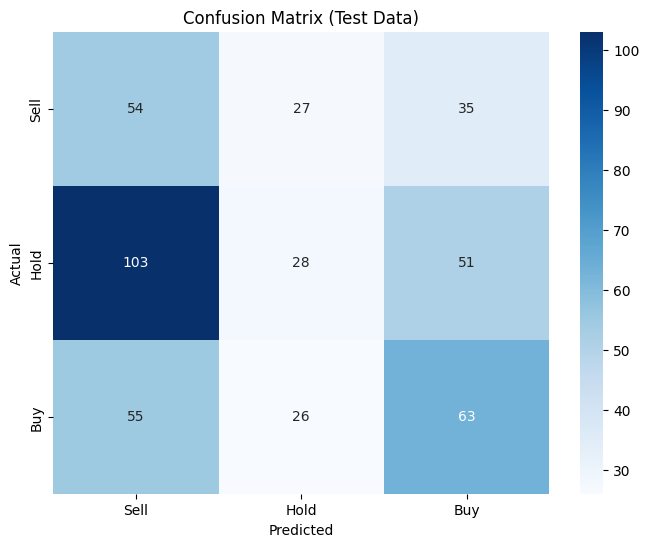

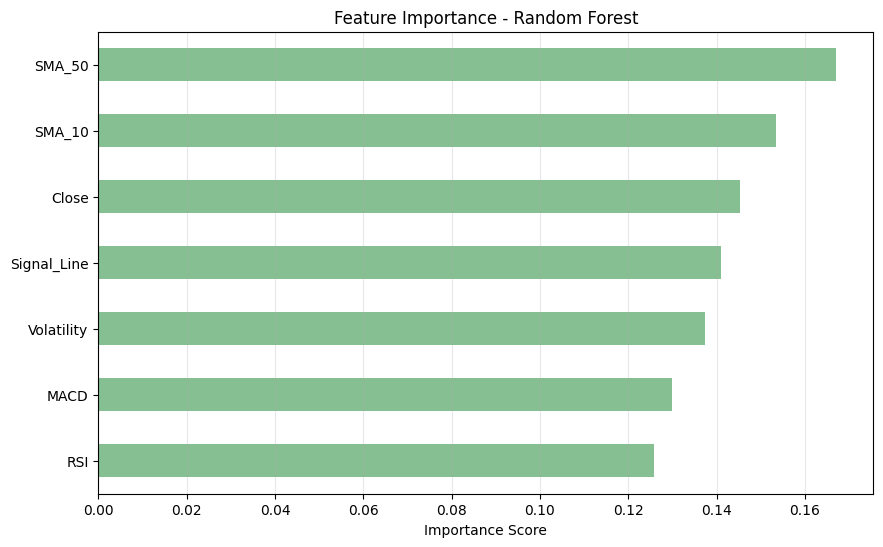

Visualization images saved


In [8]:
# MODEL ASSESSMENT
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test)

# Text Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sell', 'Hold', 'Buy'], 
            yticklabels=['Sell', 'Hold', 'Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Data)')
plt.savefig('images/confusion_matrix.png')
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='#86bf91')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.grid(axis='x', alpha=0.3)
plt.savefig('images/feature_importance.png')
plt.show()

print("Visualization images saved")

In [9]:
# LIVE PREDICTOR
def predict_live(ticker, model):
    print(f"\nFetching live data for {ticker}...")
    
    # Download last 3 months to ensure rolling windows are full
    data = yf.download(ticker, period="3mo", interval="1d", progress=False, auto_adjust=True)
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
        
    # Re-calculate Indicators
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    
    # RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=14, adjust=False).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    data['Volatility'] = data['Close'].pct_change().rolling(window=10).std()
    
    # Select the last row (Today)
    latest = data.iloc[[-1]][['Close', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'Volatility']]
    
    # Predict
    prediction = model.predict(latest)[0]
    probs = model.predict_proba(latest)[0]
    
    map_dict = {1: "BUY", -1: "SELL", 0: "HOLD"}
    
    print(f"Current Price: ${latest['Close'].values[0]:.2f}")
    print(f"Model Prediction: {map_dict[prediction]}")
    print(f"Confidence: Buy {probs[2]:.2f} | Hold {probs[1]:.2f} | Sell {probs[0]:.2f}")

# Run it
predict_live("AAPL", model)


Fetching live data for AAPL...
Current Price: $278.78
Model Prediction: SELL
Confidence: Buy 0.09 | Hold 0.24 | Sell 0.67
